# 1D TDEM inversion using the cylindrical mesh

In this example, we perform a 1D time domain electromagnetic inverion using a cylindrical mesh. 

In [1]:
from SimPEG import Mesh, Maps, Utils, DataMisfit, Regularization, Optimization, Inversion, InvProblem, Directives
import numpy as np
from SimPEG.EM import FDEM, TDEM, mu_0
import matplotlib.pyplot as plt
import matplotlib
try:
    from pymatsolver import Pardiso as Solver
except ImportError:
    from SimPEG import SolverLU as Solver

%matplotlib inline

In [13]:
from matplotlib import rcParams
rcParams['font.size'] = 14

# Set up cylindrically symmeric mesh

In [14]:
cs, ncx, ncz, npad = 10., 15, 25, 13  # padded cyl mesh
hx = [(cs, ncx), (cs, npad, 1.3)]
hz = [(cs, npad, -1.3), (cs, ncz), (cs, npad, 1.3)]
mesh = Mesh.CylMesh([hx, 1, hz], '00C')

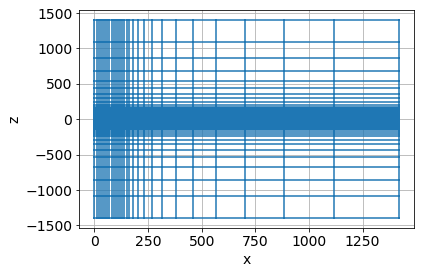

In [15]:
mesh.plotGrid()

# Conductivity model

In [16]:
layerz = np.r_[-200., -100.]
layer = (mesh.vectorCCz >= layerz[0]) & (mesh.vectorCCz <= layerz[1])
active = mesh.vectorCCz < 0.
sig_half = 1e-2  # Half-space conductivity
sig_air = 1e-8  # Air conductivity
sig_layer = 5e-2  # Layer conductivity
sigma = np.ones(mesh.nCz)*sig_air
sigma[active] = sig_half
sigma[layer] = sig_layer

Text(0,0.5,'z (m)')

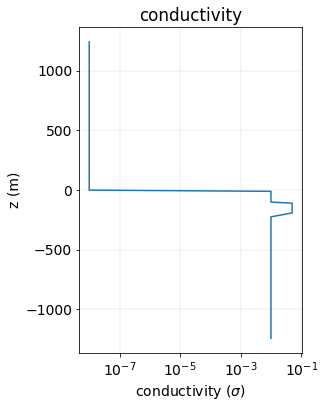

In [18]:
fig, ax = plt.subplots(1,1, figsize = (4, 6))
ax.semilogx(sigma, mesh.vectorCCz)
ax.grid(which = 'major', linestyle = '-', linewidth=0.2)
ax.set_title('conductivity')
ax.set_xlabel('conductivity ($\sigma$)')
ax.set_ylabel('z (m)')

# Mapping

In [6]:
actMap = Maps.InjectActiveCells(mesh, active, np.log(1e-8), nC=mesh.nCz)
mapping = Maps.ExpMap(mesh) * Maps.SurjectVertical1D(mesh) * actMap
mtrue = np.log(sigma[active])

Text(0,0.5,'z (m)')

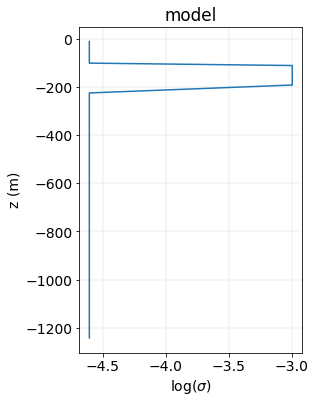

In [19]:
fig, ax = plt.subplots(1,1, figsize = (4, 6))
ax.plot(mtrue, mesh.vectorCCz[active])
ax.grid(which = 'major', linestyle = '-', linewidth=0.2)
ax.set_title('model')
ax.set_xlabel('log($\sigma$)')
ax.set_ylabel('z (m)')

# Survey

In [20]:
# TDEM survey
rxlocs = Utils.ndgrid([np.r_[50.], np.r_[0], np.r_[0.]])
srcLoc = np.r_[0., 0., 0.]
times = np.logspace(-4, np.log10(2e-3), 10)

print('min diffusion distance ', 1.28*np.sqrt(times.min()/(sig_half*mu_0)),
      'max diffusion distance ', 1.28*np.sqrt(times.max()/(sig_half*mu_0)))
rx = TDEM.Rx.Point_b(rxlocs, times, 'z')
src = TDEM.Src.MagDipole(
    [rx],
    waveform=TDEM.Src.StepOffWaveform(),
    loc=srcLoc  # same src location as FDEM problem
)

surveyTD = TDEM.Survey([src])


min diffusion distance  114.18394343377736 max diffusion distance  510.64611891383385


# Problem

In [21]:
prbTD = TDEM.Problem3D_b(mesh, sigmaMap=mapping, Solver=Solver)
prbTD.timeSteps = [(5e-5, 10), (1e-4, 10), (5e-4, 10)]
prbTD.pair(surveyTD)

std = 0.03
surveyTD.makeSyntheticData(mtrue, std)
surveyTD.std = std
surveyTD.eps = np.linalg.norm(surveyTD.dtrue)*1e-5

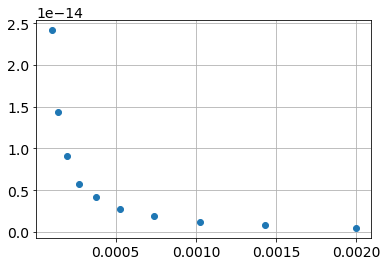

In [22]:
plt.plot(times, surveyTD.dobs, 'o')
plt.grid(which = 'both')

# set up the inversion

In [23]:
 # Inversion Directives
beta = Directives.BetaSchedule(coolingFactor=4, coolingRate=3)
betaest = Directives.BetaEstimate_ByEig(beta0_ratio=2.)
target = Directives.TargetMisfit()
directiveList = [beta, betaest, target]

In [24]:
dmisfit = DataMisfit.l2_DataMisfit(surveyTD)
regMesh = Mesh.TensorMesh([mesh.hz[mapping.maps[-1].indActive]])
reg = Regularization.Simple(regMesh)
opt = Optimization.InexactGaussNewton(maxIterCG=10)
invProb = InvProblem.BaseInvProblem(dmisfit, reg, opt)

# Run the inversion

In [25]:
inv = Inversion.BaseInversion(invProb, directiveList=directiveList)
m0 = np.log(np.ones(mtrue.size)*sig_half)
reg.alpha_s = 5e-1
reg.alpha_x = 1.
prbTD.counter = opt.counter = Utils.Counter()
opt.remember('xc')
moptTD = inv.run(m0)

SimPEG.InvProblem will set Regularization.mref to m0.

    SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
    ***Done using same Solver and solverOpts as the problem***
model has any nan: 0
============================ Inexact Gauss Newton ============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  1.14e+02  5.83e+02  0.00e+00  5.83e+02    2.54e+02      0              
   1  1.14e+02  2.20e+02  8.59e-01  3.18e+02    5.16e+01      0              
   2  1.14e+02  1.57e+02  1.27e+00  3.02e+02    1.92e+01      0   Skip BFGS  
   3  2.84e+01  1.41e+02  1.40e+00  1.81e+02    1.10e+02      0   Skip BFGS  
   4  2.84e+01  1.41e+01  3.27e+00  1.07e+02    2.04e+01      0              
   5  2.84e+01  1.23e+01  3.22e+00  1.04e+02    5.08e+00      0              
   6  7.10e+00  1.20e+01  3.21e+00  3.48e+01    4.06e+01      0   

# Plot the results

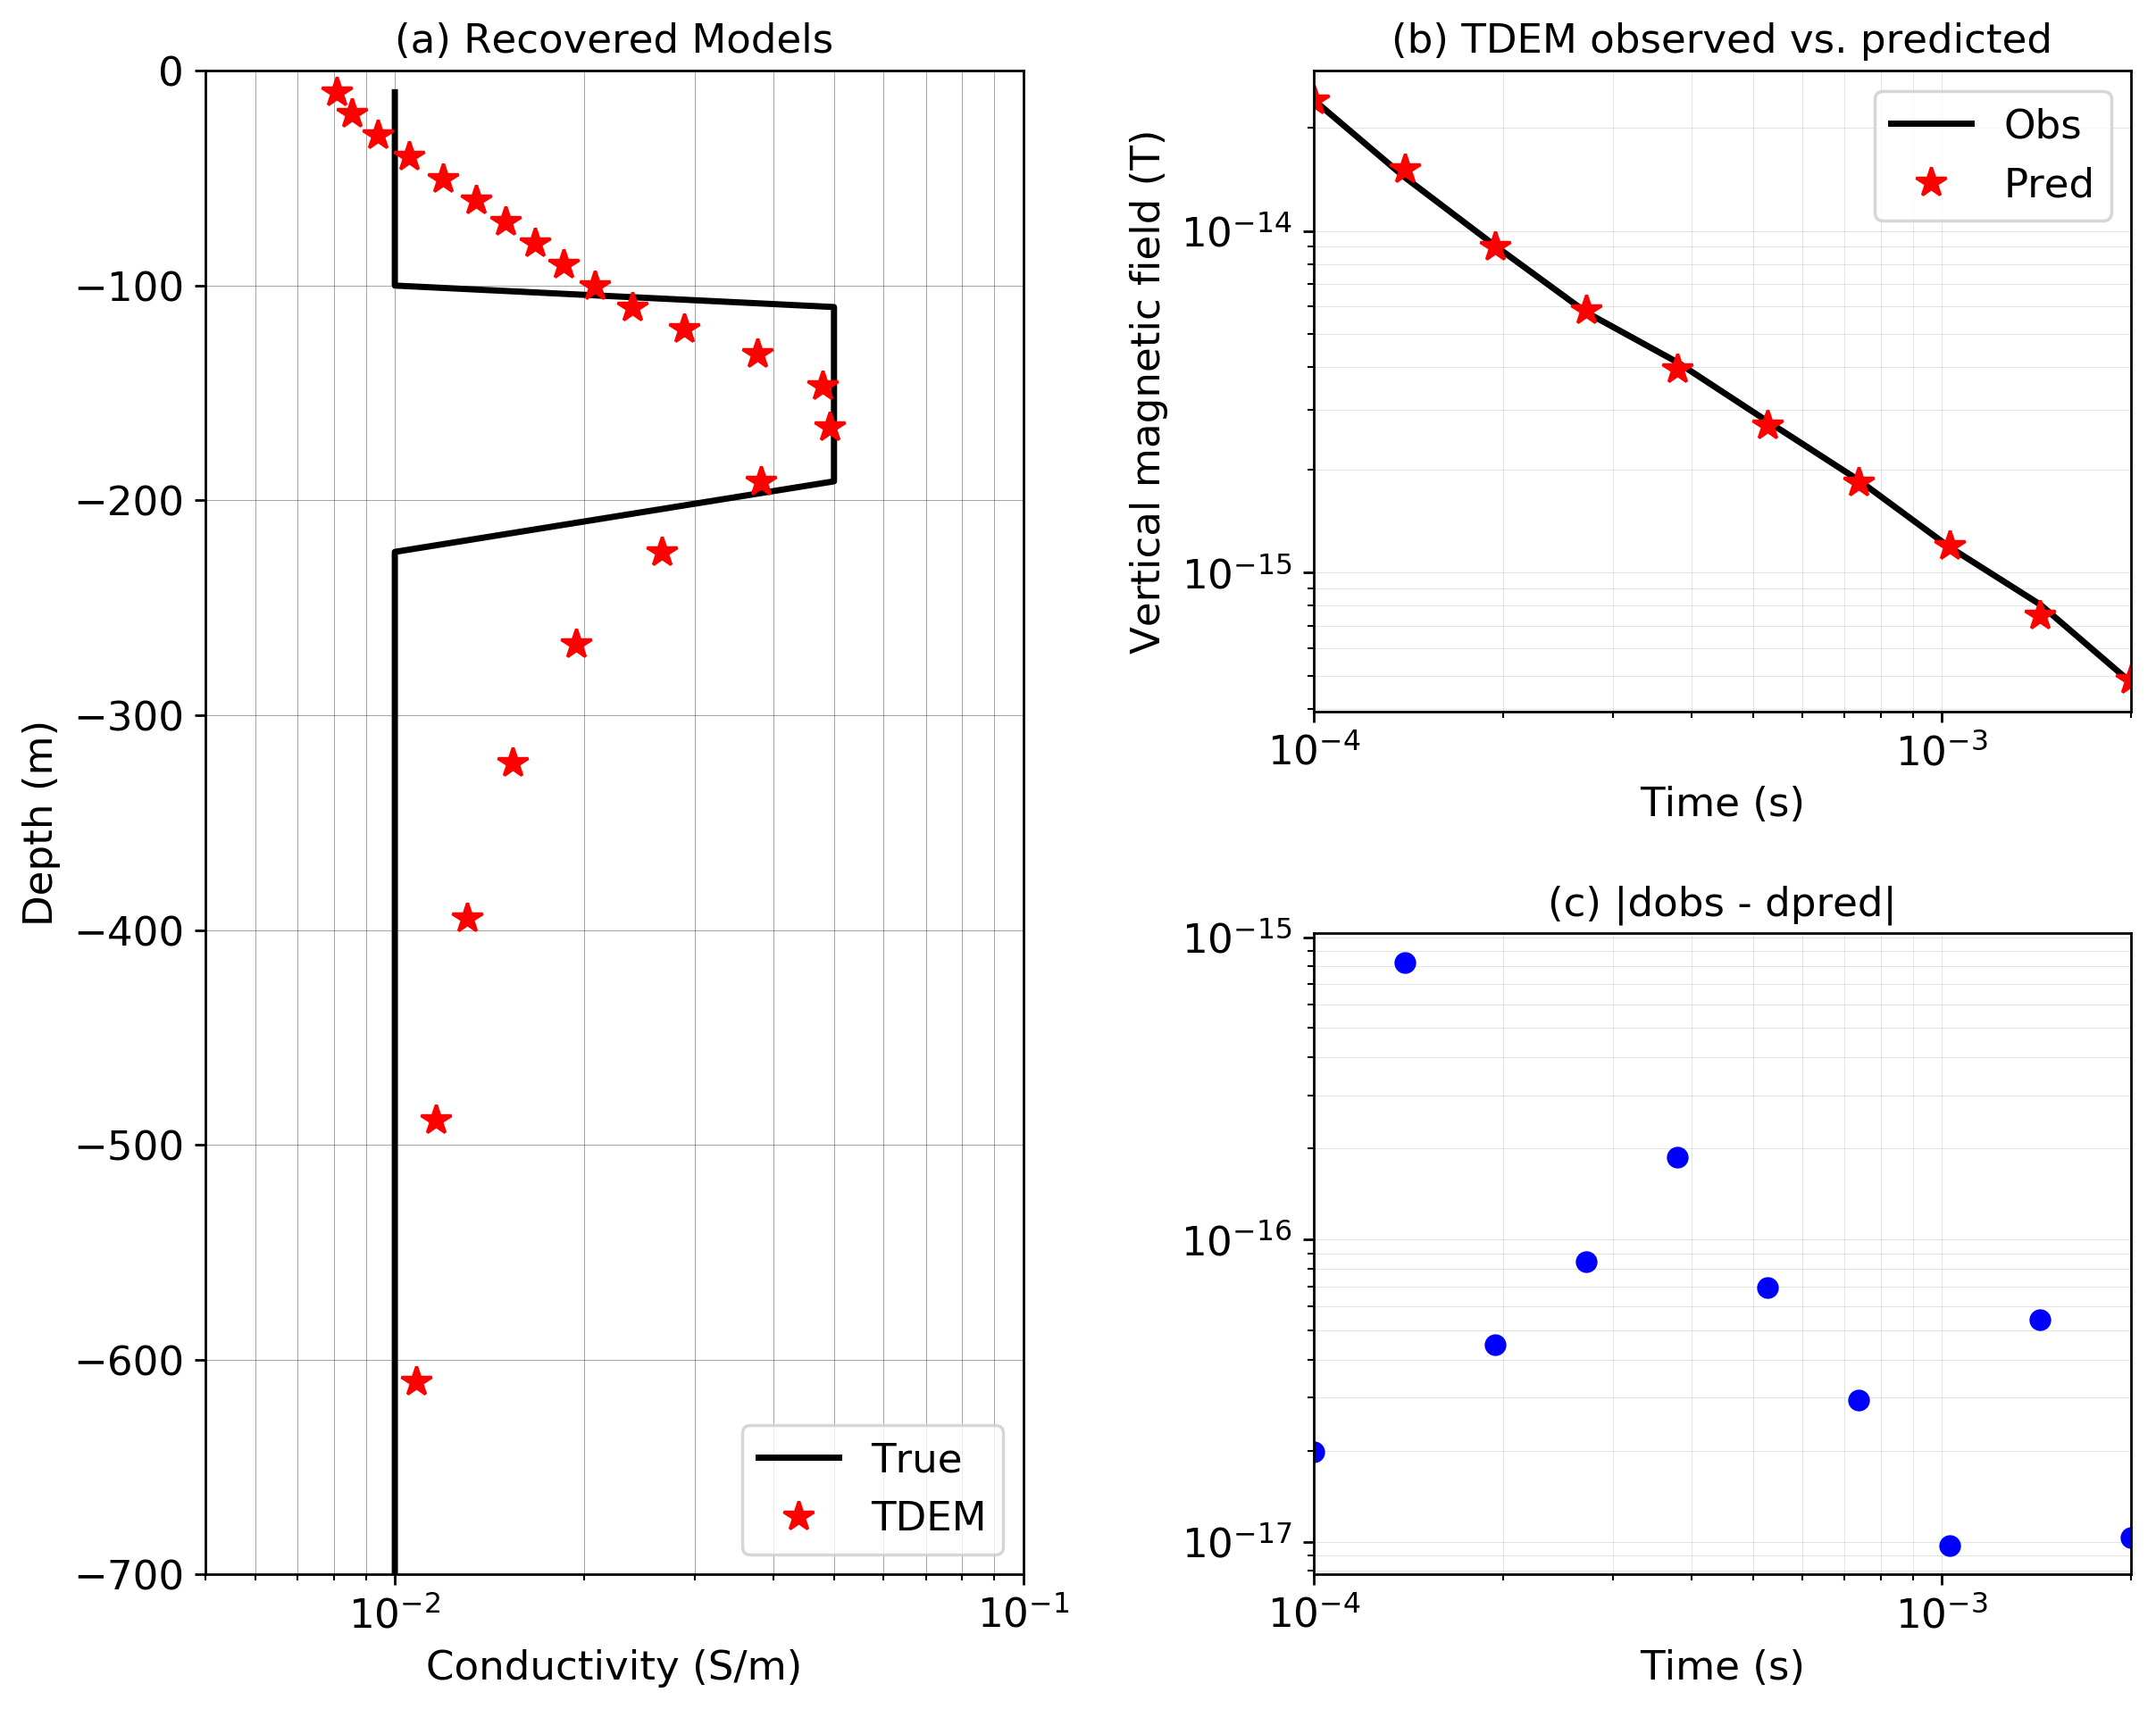

In [27]:
plt.figure(figsize=(10, 8), dpi=250)
ax0 = plt.subplot2grid((2, 2), (0, 0), rowspan=2)
ax1 = plt.subplot2grid((2, 2), (0, 1))
ax2 = plt.subplot2grid((2, 2), (1, 1))

fs = 13  # fontsize
matplotlib.rcParams['font.size'] = fs

# Plot the model
ax0.semilogx(sigma[active], mesh.vectorCCz[active], 'k-', lw=2)
ax0.semilogx(np.exp(moptTD), mesh.vectorCCz[active], 'r*', ms=10)
ax0.set_ylim(-700, 0)
ax0.set_xlim(5e-3, 1e-1)

ax0.set_xlabel('Conductivity (S/m)', fontsize=fs)
ax0.set_ylabel('Depth (m)', fontsize=fs)
ax0.grid(
    which='both', color='k', alpha=0.5, linestyle='-', linewidth=0.2
)
ax0.legend(['True', 'TDEM'], fontsize=fs, loc=4)

# plot the data misfits - negative b/c we choose positive to be in the
# direction of primary
dpred = surveyTD.dpred(moptTD)
ax1.loglog(times, surveyTD.dobs, 'k-', lw=2)
ax1.loglog(times, dpred, 'r*', ms=10)
ax1.set_xlim(times.min(), times.max())

# plot the difference
ax2.loglog(times, np.abs(dpred-surveyTD.dobs), 'bo')
ax2.set_xlim(times.min(), times.max())
ax2.grid(which='both', alpha=0.5, linestyle='-', linewidth=0.2)
ax2.set_xlabel('Time (s)', fontsize=fs)
ax2.set_title('(c) |dobs - dpred|', fontsize=fs)

# Labels, gridlines, etc
ax1.grid(which='both', alpha=0.5, linestyle='-', linewidth=0.2)
ax1.set_xlabel('Time (s)', fontsize=fs)
ax1.set_ylabel('Vertical magnetic field (T)', fontsize=fs)
ax1.legend(("Obs", "Pred"), fontsize=fs)

ax0.set_title("(a) Recovered Models", fontsize=fs)
ax1.set_title("(b) TDEM observed vs. predicted", fontsize=fs)

plt.tight_layout(pad=1.5)